In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
metadata_col_specs = [
    (0,  12),
    (12, 21),
    (21, 31),
    (31, 38),
    (38, 41),
    (41, 72),
    (72, 76),
    (76, 80),
    (80, 86)
]

metadata_names = [
    "ID",
    "LATITUDE",
    "LONGITUDE",
    "ELEVATION",
    "STATE",
    "NAME",
    "GSN FLAG",
    "HCN/CRN FLAG",
    "WMO ID"]

metadata_dtype = {
    "ID": str,
    "STATE": str,
    "NAME": str,
    "GSN FLAG": str,
    "HCN/CRN FLAG": str,
    "WMO ID": str
    }


# Data specs #

data_header_names = [
    "ID",
    "YEAR",
    "MONTH",
    "ELEMENT"]

data_header_col_specs = [
    (0,  11),
    (11, 15),
    (15, 17),
    (17, 21)]

data_header_dtypes = {
    "ID": str,
    "YEAR": int,
    "MONTH": int,
    "ELEMENT": str}

data_col_names = [[
    "VALUE" + str(i + 1),
    "MFLAG" + str(i + 1),
    "QFLAG" + str(i + 1),
    "SFLAG" + str(i + 1)]
    for i in range(31)]
# Join sub-lists
data_col_names = sum(data_col_names, [])

data_replacement_col_names = [[
    ("VALUE", i + 1),
    ("MFLAG", i + 1),
    ("QFLAG", i + 1),
    ("SFLAG", i + 1)]
    for i in range(31)]
# Join sub-lists
data_replacement_col_names = sum(data_replacement_col_names, [])
data_replacement_col_names = pd.MultiIndex.from_tuples(
    data_replacement_col_names,
    names=['VAR_TYPE', 'DAY'])

data_col_specs = [[
    (21 + i * 8, 26 + i * 8),
    (26 + i * 8, 27 + i * 8),
    (27 + i * 8, 28 + i * 8),
    (28 + i * 8, 29 + i * 8)]
    for i in range(31)]
data_col_specs = sum(data_col_specs, [])

data_col_dtypes = [{
    "VALUE" + str(i + 1): int,
    "MFLAG" + str(i + 1): str,
    "QFLAG" + str(i + 1): str,
    "SFLAG" + str(i + 1): str}
    for i in range(31)]
data_header_dtypes.update({k: v for d in data_col_dtypes for k, v in d.items()})



def read_ghcn_data_file(filename="C:/Users/ban563/Downloads/ghcnd_all.tar/ghcnd_all/ghcnd_all/KZ000038341.dly",
                        variables=None, include_flags=False,
                        dropna='all'):
    """Reads in all data from a GHCN .dly data file

    :param filename: path to file
    :param variables: list of variables to include in output dataframe
        e.g. ['TMAX', 'TMIN', 'PRCP']
    :param include_flags: Whether to include data quality flags in the final output
    :returns: Pandas dataframe
    """

    df = pd.read_fwf(
        filename,
        colspecs=data_header_col_specs + data_col_specs,
        names=data_header_names + data_col_names,
        index_col=data_header_names,
        dtype=data_header_dtypes
        )

    if variables is not None:
        df = df[df.index.get_level_values('ELEMENT').isin(variables)]

    df.columns = data_replacement_col_names

    if not include_flags:
        df = df.loc[:, ('VALUE', slice(None))]
        df.columns = df.columns.droplevel('VAR_TYPE')

    df = df.stack(level='DAY').unstack(level='ELEMENT')

    if dropna:
        df.replace(-9999.0, pd.np.nan, inplace=True)
        df.dropna(how=dropna, inplace=True)

    # replace the entire index with the date.
    # This loses the station ID index column!
    # This will usuall fail if dropna=False, since months with <31 days
    # still have day=31 columns
    df.index = pd.to_datetime(
        df.index.get_level_values('YEAR') * 10000 +
        df.index.get_level_values('MONTH') * 100 +
        df.index.get_level_values('DAY'),
        format='%Y%m%d')
    
    df.TAVG = df.TAVG/10
    df.TMAX = df.TMAX/10
    df.TMIN = df.TMIN/10
    return df


In [3]:
df = read_ghcn_data_file()
df = df.reset_index()
df['year'] = df.YEAR.apply(lambda x: x.year)
df['month'] = df.YEAR.apply(lambda x: x.month)
df['day'] = df.YEAR.apply(lambda x: x.day)

In [4]:
mask = (df['YEAR'] > '2004-12-31') & (df['YEAR'] <= '2014-12-31')
fifteen = (df['YEAR'] > '2014-12-31') & (df['YEAR'] <= '2015-12-31')

In [5]:
fourteen = df.loc[mask]
scatter = df.loc[fifteen]

In [6]:
fifteen = pd.merge(scatter.groupby(by=['month', 'day'])['TMAX'].max().reset_index(), scatter.groupby(by=['month', 'day'])['TMIN'].min().reset_index(), on =['day', 'month'])

In [7]:
fifteen.shape

(344, 4)

In [8]:
weather = pd.merge(fourteen.groupby(by=['month', 'day'])['TMAX'].max().reset_index(), fourteen.groupby(by=['month', 'day'])['TMIN'].min().reset_index(), on = ['month', 'day'])

In [9]:
fifteen = fifteen.rename(columns = {'TMAX' : "2015_max", 'TMIN' : "2015_min"})

In [10]:
check = pd.merge(weather, fifteen, on = ['day','month'], how = 'outer')

In [11]:
Hot = []
Cold = []
for i in range(check.shape[0]):
    if check.TMAX[i] < check['2015_max'][i]:
        node = {'temp' : check['2015_max'][i], 'x': i}
        Hot.append(node)
    if check.TMIN[i] > check['2015_min'][i]:
        node = {'temp' : check['2015_min'][i], 'x': i}
        Cold.append(node)

In [12]:
Hot = pd.DataFrame(Hot)

In [13]:
Cold = pd.DataFrame(Cold)

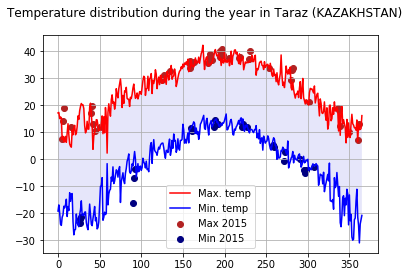

In [14]:
fig, ax = plt.subplots()
x = np.arange(weather.shape[0])
plt.plot( x, weather.TMAX, color='red',  label = 'Max. temp')
plt.plot( x, weather.TMIN, color='blue',  label = 'Min. temp')
ax.fill_between(x, weather.TMAX, weather.TMIN,  facecolor='lavender', interpolate=True)
plt.scatter(Hot.x, Hot.temp, label = "Max 2015", color = 'firebrick')
plt.scatter(Cold.x, Cold.temp, label = "Min 2015", color = 'navy')
ax.grid()
ax.legend()
fig.suptitle('Temperature distribution during the year in Taraz (KAZAKHSTAN)')

plt.savefig('TarazTemp.png')